<a href="https://colab.research.google.com/github/Tixonmavrin/Zindi-Zimnat-Insurance-Recommendation-Challenge/blob/master/Baseline1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Zimnat Insurance Recommendation Challenge
Can you predict which insurance products existing clients will want next?
###Baseline with catboost

### Get data

In [43]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import copy
import matplotlib.pyplot as plt
%matplotlib inline

import os
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, VotingClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
from sklearn import preprocessing
from sklearn import metrics
import numpy as np
import pandas as pd
from time import time
import pprint
import joblib
from sklearn.model_selection import KFold
from xgboost.sklearn import XGBClassifier 
import warnings
warnings.filterwarnings("ignore")

# Classifiers
from catboost import CatBoostClassifier

# Model selection
from sklearn.model_selection import StratifiedKFold

# Metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer

# Skopt functions
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, VerboseCallback, DeltaXStopper
from skopt.space import Real, Categorical, Integer
from time import time

In [2]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

# New Section

### New format

In [3]:
X_train = []
X_train_columns = train.columns
c = 0
for v in train.values:
    info = v[:8]
    binary = v[8:]
    index = [k for k, i in enumerate(binary) if i == 1]
    for i in index:
        c+=1
        for k in range(len(binary)):
            if k == i:
                binary_transformed = list(copy.copy(binary))
                binary_transformed[i] = 0
                X_train.append(list(info) + binary_transformed + [X_train_columns[8+k]] + [c])

X_train = pd.DataFrame(X_train)
X_train.columns = ['ID', 'join_date', 'sex', 'marital_status', 'birth_year', 'branch_code',
       'occupation_code', 'occupation_category_code', 'P5DA', 'RIBP', '8NN1',
       '7POT', '66FJ', 'GYSR', 'SOP4', 'RVSZ', 'PYUQ', 'LJR9', 'N2MW', 'AHXO',
       'BSTQ', 'FM3X', 'K6QO', 'QBOL', 'JWFN', 'JZ9D', 'J9JW', 'GHYX', 'ECY3', 'product_pred', 'ID2']

In [4]:
X_test = []
true_values = []
c = 0
for v in test.values:
    c += 1
    info = v[:8]
    binary = v[8:]
    index = [k for k, i in enumerate(binary) if i == 1]
    X_test.append(list(info) + list(binary) + [c])
    for k in test.columns[8:][index]:
        true_values.append(v[0] + ' X ' + k)

X_test = pd.DataFrame(X_test)
X_test.columns = ['ID', 'join_date', 'sex', 'marital_status', 'birth_year', 'branch_code',
       'occupation_code', 'occupation_category_code', 'P5DA', 'RIBP', '8NN1',
       '7POT', '66FJ', 'GYSR', 'SOP4', 'RVSZ', 'PYUQ', 'LJR9', 'N2MW', 'AHXO',
       'BSTQ', 'FM3X', 'K6QO', 'QBOL', 'JWFN', 'JZ9D', 'J9JW', 'GHYX', 'ECY3', 'ID2']

### Transform data

In [5]:
features_train = []
features_test = []
columns = []

append_features = ['P5DA', 'RIBP', '8NN1', '7POT', '66FJ', 'GYSR', 'SOP4', 'RVSZ', 'PYUQ', 'LJR9', 
'N2MW', 'AHXO','BSTQ', 'FM3X', 'K6QO', 'QBOL', 'JWFN', 'JZ9D', 'J9JW', 'GHYX', 
'ECY3', 'ID', 'ID2', 'join_date', 'sex', 'marital_status', 'branch_code', 'occupation_code', 'occupation_category_code',
'birth_year']
for v in append_features:
    features_train.append(X_train[v].values.reshape(-1, 1))
    features_test.append(X_test[v].values.reshape(-1, 1))
    columns.append(np.array([v]))

y_train = X_train[['product_pred']]

In [6]:
features_train = np.concatenate(features_train, axis=1)
features_test = np.concatenate(features_test, axis=1)
columns = np.concatenate(np.array(columns))

X_train = pd.DataFrame(features_train)
X_train.columns = columns
X_test = pd.DataFrame(features_test)
X_test.columns = columns

### New features

In [7]:
X_train['date1'] = X_train['join_date'].apply(lambda x: int(x.split('/')[0]) if (x == x) else np.nan)
X_train['date2'] = X_train['join_date'].apply(lambda x: int(x.split('/')[1]) if (x == x) else np.nan)
X_train['date3'] = X_train['join_date'].apply(lambda x: int(x.split('/')[2]) if (x == x) else np.nan)
X_train.drop('join_date', axis=1, inplace=True)

X_test['date1'] = X_test['join_date'].apply(lambda x: int(x.split('/')[0]) if (x == x) else np.nan)
X_test['date2'] = X_test['join_date'].apply(lambda x: int(x.split('/')[1]) if (x == x) else np.nan)
X_test['date3'] = X_test['join_date'].apply(lambda x: int(x.split('/')[2]) if (x == x) else np.nan)
X_test.drop('join_date', axis=1, inplace=True)

X_train['date_diff'] = X_train['date3'] - X_train['birth_year']
X_test['date_diff'] = X_test['date3'] - X_test['birth_year']

### Change types

In [8]:
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)
y_train = y_train.fillna(0)

In [9]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data = X_train.append(X_test)
for v in ['sex', 'marital_status', 'branch_code', 'occupation_code', 'occupation_category_code',]:
    data.loc[:,v] = le.fit_transform(data.loc[:,v])
X_train = data[:X_train.shape[0]]
X_test = data[-X_test.shape[0]:]

In [10]:
le.fit(y_train.iloc[:,0])
y_train = pd.DataFrame(le.transform(y_train.iloc[:,0]))
y_train.columns = ['target']

In [11]:
pd.set_option('display.max_columns', None)
train.head()

,ID,join_date,sex,marital_status,birth_year,branch_code,occupation_code,occupation_category_code,P5DA,RIBP,8NN1,7POT,66FJ,GYSR,SOP4,RVSZ,PYUQ,LJR9,N2MW,AHXO,BSTQ,FM3X,K6QO,QBOL,JWFN,JZ9D,J9JW,GHYX,ECY3
0,4WKQSBB,1/2/2019,F,M,1987,1X1H,2A7I,T4MS,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
1,CP5S02H,1/6/2019,F,M,1981,UAOD,2A7I,T4MS,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
2,2YKDILJ,1/6/2013,M,U,1991,748L,QZYX,90QI,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1
3,2S9E81J,1/8/2019,M,M,1990,1X1H,BP09,56SI,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
4,BHDYVFT,1/8/2019,M,M,1990,748L,NO3L,T4MS,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0


In [12]:
pd.set_option('display.max_columns', None)
X_train.head()

,P5DA,RIBP,8NN1,7POT,66FJ,GYSR,SOP4,RVSZ,PYUQ,LJR9,N2MW,AHXO,BSTQ,FM3X,K6QO,QBOL,JWFN,JZ9D,J9JW,GHYX,ECY3,ID,ID2,sex,marital_status,branch_code,occupation_code,occupation_category_code,birth_year,date1,date2,date3,date_diff
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,4WKQSBB,1,0,2,0,19,5,1987,1.0,2.0,2019.0,32.0
1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,4WKQSBB,2,0,2,0,19,5,1987,1.0,2.0,2019.0,32.0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,CP5S02H,3,0,2,11,19,5,1981,1.0,6.0,2019.0,38.0
3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,CP5S02H,4,0,2,11,19,5,1981,1.0,6.0,2019.0,38.0
4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,2YKDILJ,5,1,6,3,185,1,1991,1.0,6.0,2013.0,22.0


In [13]:
data = X_train.append(X_test)

In [14]:
freq_1 = data['marital_status'].value_counts()
data['marital_status_fe'] = data['marital_status'].map(freq_1)

freq_2 = data['branch_code'].value_counts()
data['branch_code_fe'] = data['branch_code'].map(freq_2)

freq_3 = data['occupation_category_code'].value_counts()
data['occupation_category_code_fe'] = data['occupation_category_code'].map(freq_3)
  

In [15]:
## Squaring the features 

data['marital_status_sq'] = data['marital_status']**2
data['branch_code_sq'] = data['branch_code']**2
data['occupation_code_sq'] = data['occupation_code']**2
data['occupation_category_code_sq'] = data['occupation_category_code']**2
data['date_diff_sq'] = data['date_diff']**2

data['marital_status_cube'] = data['marital_status']**3
data['branch_code_cube'] = data['branch_code']**3
data['occupation_code_cube'] = data['occupation_code']**3
data['occupation_category_code_cube'] = data['occupation_category_code']**3
data['date_diff_cube'] = data['date_diff']**3

data['marital_status_log'] = (data['marital_status']+1).transform(np.log)
data['branch_code_log'] = (data['branch_code']+1).transform(np.log)
data['occupation_code_cube'] = (data['occupation_code']+1).transform(np.log)
data['occupation_category_code_log'] = (data['occupation_category_code']+1).transform(np.log)
data['date_diff_log'] = (data['date_diff']+1).transform(np.log)

data['sex*marital_status'] = data['sex'] * data['marital_status']
data['occupation_code*occupation_cat_code'] = data['occupation_code'] * data['occupation_category_code']
# data = data.drop(['marital_status', 'branch_code', 'occupation_category_code'], axis=1)
# X_train = data[:X_train.shape[0]]
# X_test = data[-X_test.shape[0]:]

In [16]:
data.head()

,P5DA,RIBP,8NN1,7POT,66FJ,GYSR,SOP4,RVSZ,PYUQ,LJR9,N2MW,AHXO,BSTQ,FM3X,K6QO,QBOL,JWFN,JZ9D,J9JW,GHYX,ECY3,ID,ID2,sex,marital_status,branch_code,occupation_code,occupation_category_code,birth_year,date1,date2,date3,date_diff,marital_status_fe,branch_code_fe,occupation_category_code_fe,marital_status_sq,branch_code_sq,occupation_code_sq,occupation_category_code_sq,date_diff_sq,marital_status_cube,branch_code_cube,occupation_code_cube,occupation_category_code_cube,date_diff_cube,marital_status_log,branch_code_log,occupation_category_code_log,date_diff_log,sex*marital_status,occupation_code*occupation_cat_code
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,4WKQSBB,1,0,2,0,19,5,1987,1.0,2.0,2019.0,32.0,59731,3130,48918,4,0,361,25,1024.0,8,0,2.995732,125,32768.0,1.098612,0.000000,1.791759,3.496508,0,95
1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,4WKQSBB,2,0,2,0,19,5,1987,1.0,2.0,2019.0,32.0,59731,3130,48918,4,0,361,25,1024.0,8,0,2.995732,125,32768.0,1.098612,0.000000,1.791759,3.496508,0,95
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,CP5S02H,3,0,2,11,19,5,1981,1.0,6.0,2019.0,38.0,59731,8972,48918,4,121,361,25,1444.0,8,1331,2.995732,125,54872.0,1.098612,2.484907,1.791759,3.663562,0,95
3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,CP5S02H,4,0,2,11,19,5,1981,1.0,6.0,2019.0,38.0,59731,8972,48918,4,121,361,25,1444.0,8,1331,2.995732,125,54872.0,1.098612,2.484907,1.791759,3.663562,0,95
4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,2YKDILJ,5,1,6,3,185,1,1991,1.0,6.0,2013.0,22.0,6905,21481,14842,36,9,34225,1,484.0,216,27,5.225747,1,10648.0,1.945910,1.386294,0.693147,3.135494,6,185


In [17]:
X_train = data[:X_train.shape[0]]
X_test = data[-X_test.shape[0]:]

In [18]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_train, y_train, test_size=0.33, random_state=42,stratify=y_train)

In [19]:
#Defining a Cross validation function
#n_folds = 10
def classification_cv(model):
    kfold = model_selection.KFold(n_splits=10, random_state=7)
    scoring = 'accuracy'
    results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    return(print("Accuracy: %.3f (%.3f)" % (results.mean(), results.std())))

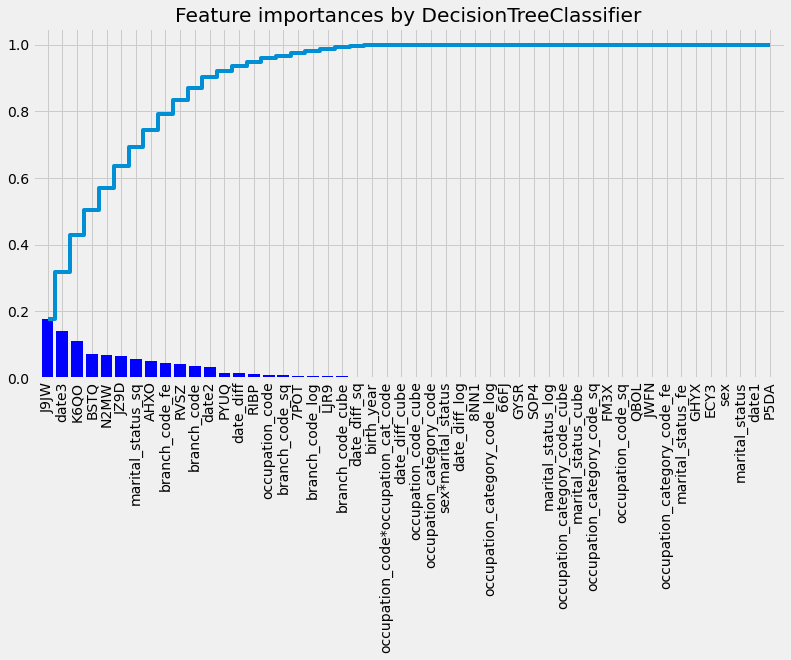

In [24]:
#Feature importance
#decision tree classifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12,6)

# Create train and test splits

dtree = tree.DecisionTreeClassifier(
    #max_depth=3,
    class_weight="balanced",
    min_weight_fraction_leaf=0.01
    )
dtree = dtree.fit(X_train_1.drop(columns=['ID', 'ID2'],axis=1),y_train_1)

## plot the importances ##
importances = dtree.feature_importances_
feat_names = X_train_1.drop(columns=['ID', 'ID2'],axis=1).columns


indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12,6))
plt.title("Feature importances by DecisionTreeClassifier")
plt.bar(range(len(indices)), importances[indices], color='blue',  align="center")
plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid', label='Cumulative')
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical',fontsize=14)
plt.xlim([-1, len(indices)])
plt.show()


In [25]:
# Creating base rate model
def base_rate_model(X) :
    y = np.zeros(X.shape[0])
    return y

In [26]:
# Check accuracy of base rate model-- same as percentage of majority class
y_base_rate = base_rate_model(X_test_1)
from sklearn.metrics import accuracy_score
print ("Base rate accuracy is %2.2f" % accuracy_score(y_test_1, y_base_rate))

Base rate accuracy is 0.01


In [50]:
xgb = XGBClassifier(learning_rate=0.1675, max_depth=10, gamma=1.976, n_estimators=550)
# model_xgb = xgb.fit(X_train.drop(columns=['ID', 'ID2'],axis=1), y_train)
# preds_xgb = model_xgb.predict_proba(X_test.drop(columns=['ID', 'ID2'],axis=1))

In [51]:
rf = RandomForestClassifier(n_estimators=200,max_depth=8,min_samples_split=10)
# model_rf = rf.fit(X_train.drop(columns=['ID', 'ID2'],axis=1), y_train)
# preds_rf = model_rf.predict_proba(X_test.drop(columns=['ID', 'ID2'],axis=1))

In [52]:
gbc = GradientBoostingClassifier(n_estimators=400,learning_rate=0.1,random_state=100,max_features=4 )
# model_gbc = gbc.fit(X_train.drop(columns=['ID', 'ID2'],axis=1), y_train)
# preds_gbc = model_gbc.predict_proba(X_test.drop(columns=['ID', 'ID2'],axis=1))

In [53]:
catb = CatBoostClassifier(depth=7, iterations= 79, learning_rate = 0.24800286296598373, )
# model_catb = catb.fit(X_train.drop(columns=['ID', 'ID2'],axis=1), y_train)
# preds_catb = model_catb.predict_proba(X_test.drop(columns=['ID', 'ID2'],axis=1))

In [54]:
eclf = VotingClassifier(estimators=[('catb', catb),('rf',rf),('xgb',xgb)], voting='soft', weights=[1,1,5])
model_eclf = eclf.fit(X_train.drop(columns=['ID', 'ID2'],axis=1), y_train)
preds_voting = model_eclf.predict_proba(X_test.drop(columns=['ID', 'ID2'],axis=1))

0:	learn: 1.0172777	total: 155ms	remaining: 12.1s
1:	learn: 0.7988666	total: 279ms	remaining: 10.7s
2:	learn: 0.7198119	total: 409ms	remaining: 10.4s
3:	learn: 0.6674187	total: 541ms	remaining: 10.2s
4:	learn: 0.6268970	total: 669ms	remaining: 9.9s
5:	learn: 0.5968690	total: 796ms	remaining: 9.68s
6:	learn: 0.5758798	total: 924ms	remaining: 9.51s
7:	learn: 0.5549092	total: 1.04s	remaining: 9.25s
8:	learn: 0.5380330	total: 1.16s	remaining: 9.05s
9:	learn: 0.5250719	total: 1.3s	remaining: 9s
10:	learn: 0.5134608	total: 1.44s	remaining: 8.89s
11:	learn: 0.5053064	total: 1.63s	remaining: 9.1s
12:	learn: 0.4950017	total: 1.78s	remaining: 9.04s
13:	learn: 0.4880423	total: 1.91s	remaining: 8.85s
14:	learn: 0.4800675	total: 2.02s	remaining: 8.62s
15:	learn: 0.4729832	total: 2.14s	remaining: 8.42s
16:	learn: 0.4674077	total: 2.25s	remaining: 8.21s
17:	learn: 0.4620749	total: 2.37s	remaining: 8.04s
18:	learn: 0.4576790	total: 2.49s	remaining: 7.88s
19:	learn: 0.4537638	total: 2.62s	remaining: 7.

KeyboardInterrupt: 

In [ ]:
y_test = pd.DataFrame(preds_voting)
y_test.columns = le.inverse_transform(y_test.columns)

### Model

### Submit

In [ ]:
answer_mass = []
for i in range(X_test.shape[0]):
    id = X_test['ID'].iloc[i]
    for c in y_test.columns:
        answer_mass.append([id + ' X ' + c, y_test[c].iloc[i]])

df_answer = pd.DataFrame(answer_mass)
df_answer.columns = ['ID X PCODE', 'Label']
for i in range(df_answer.shape[0]):
    if df_answer['ID X PCODE'].iloc[i] in true_values:
        df_answer['Label'].iloc[i] = 1.0

In [ ]:
df_answer.reset_index(drop=True, inplace=True)
df_answer.to_csv('submission47.csv', index=False)

Submit